In [1]:
%cd ..
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from melp import Detector
import melp
import math
import random

from melp.clustering.misc import*
import melp.clustering as clump
import melp.clustering.time_cluster as tclump
#from melp import TileAnalyzer
import melp.clustering.spatial_cluster as sclump
import melp.clustering.plots as clump_plt
import melp.clustering.three_frame_cluster as clump_3

plt.rcParams.update({'font.size': 16})

/home/erik/GitHub/melp
Welcome to JupyROOT 6.24/06


In [2]:
filename_trirec = "./testdata/trirec/trirec1.root"
filename_sorted = "./testdata/sorted/sorted1.root"
#filename_sorted_big = "/home/erik/GitLab_KIP/melp/root_files/big_run_data/sorted1.root"
#filename_sorted_big = "./testdata/sorted/sorted1_big.root"
#fix
filename_sorted_big = "./testdata/sorted/root_files_fixed/mu3e_sorted_000127.root"

file = ROOT.TFile(filename_sorted)
ttree_mu3e = file.Get("mu3e")
ttree_mu3e_mc = file.Get("mu3e_mchits")
ttree_sensor = file.Get("alignment/sensors")
ttree_tiles = file.Get("alignment/tiles")

file_rec = ROOT.TFile(filename_trirec)
ttree_trirec = file_rec.Get("frames")
ttree_trirec_mc = file_rec.Get("frames_mc")
ttree_mu3e_segs = file_rec.Get("segs")

file_big = ROOT.TFile(filename_sorted_big)
ttree_mu3e_big = file_big.Get("mu3e")
ttree_mu3e_mc_big = file_big.Get("mu3e_mchits")
ttree_sensor_big = file_big.Get("alignment/sensors")
ttree_tiles_big = file_big.Get("alignment/tiles")

In [3]:
mu3e_detector = Detector.initFromROOT(filename_sorted)

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [4]:
melp.select(mu3e_detector)
print(mu3e_detector)

Detector(TileDetector=Loaded Tiles: 5824, SensorModules=<melp.src.sensor.SensorModule object at 0x7fc6cbb13ca0>))


In [5]:
melp.addTileHits("./testdata/sorted/sorted1.root", truth=False, traj=False)
mu3e_detector.info()

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  [1]
  - Loaded Runs (Pixel):  []
------------------------------


In [6]:
#select frame to analyze
frame_used = 35 #28 #182
ttree_mu3e.GetEntry(frame_used)
ttree_mu3e_big.GetEntry(frame_used)

#set time threshold
time_threshold_used = 2 #0.4

#build masks (and deconstruct them into arrays)
#masks = sclump.build_mask_detector_class(filename_sorted, frame_used, mu3e_detector, mask_type = "big")
masks, __ = clump.masks.build_mask_around_cluster_master(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector, frame_used, time_threshold = time_threshold_used, mask_type = "big", rec_type = "pixelpixel")

keys = []
values = []
for key in masks.keys():
    keys.append(key)
    values.append(masks[key])
    
#mu3e_detector.TileDetector.tile[keys[0]].id
#mu3e_detector.TileDetector.tile[keys[0]].hits
#print(values[0])

# Pure time clustering

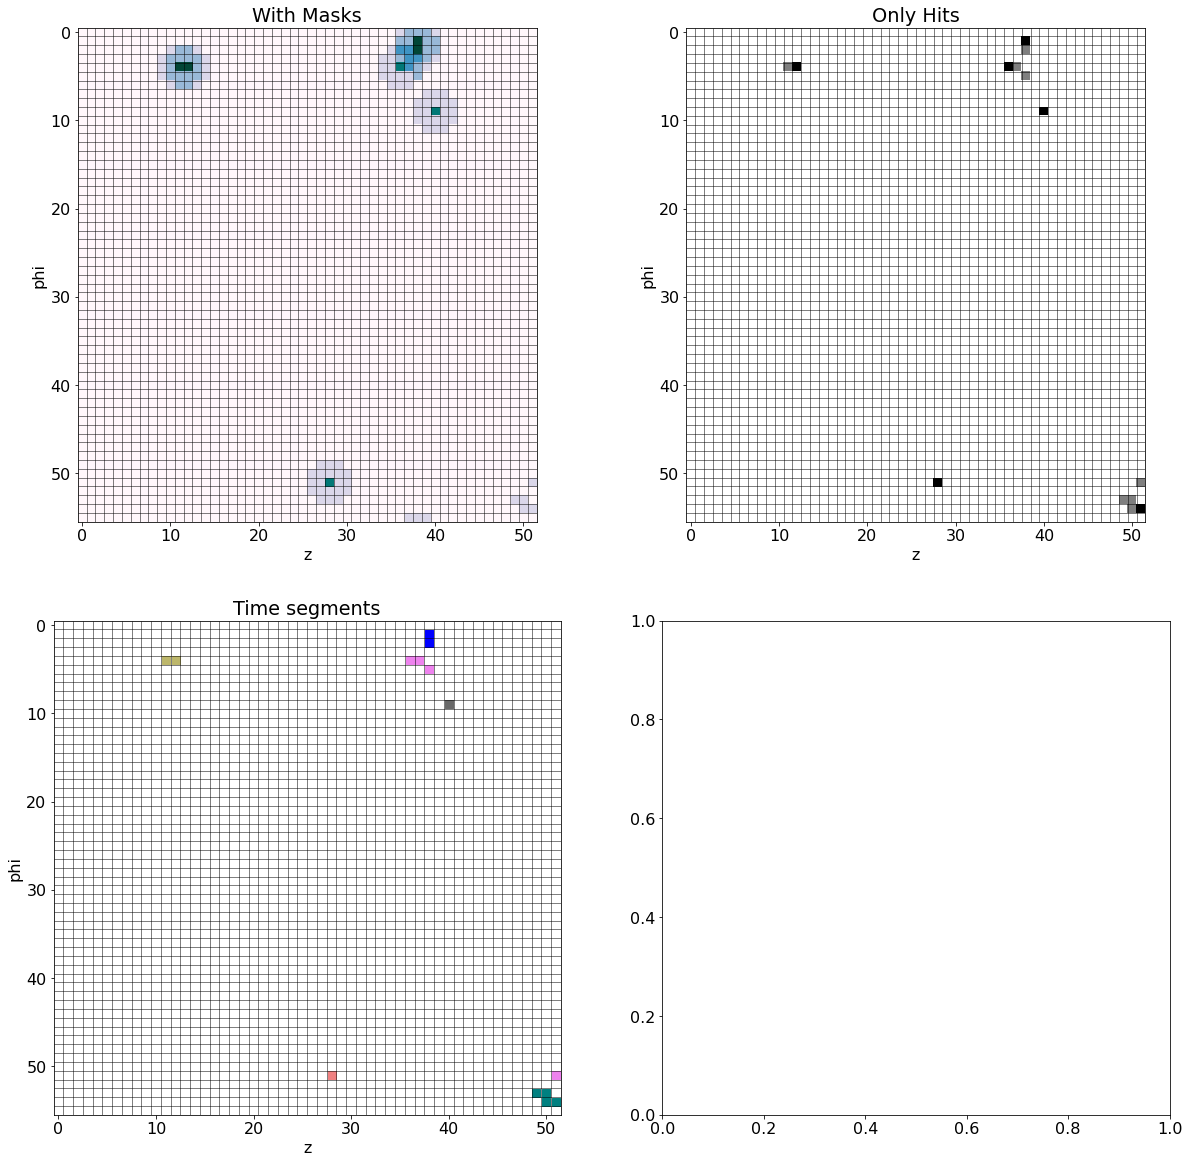

In [7]:
grid = np.zeros((52,56))

#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#add hits in frame
if all_hits == True:
    for tile_id in mu3e_detector.TileDetector.tile:
        if tile_id < 300000:
            tile = mu3e_detector.TileDetector.tile[tile_id]
            for hits in tile.hits:
                if hits.frame_id in [frame_used]:
                    y = tile.row()
                    x = tile.column()
                    grid[x][y] += 1

#add masks
if all_hits == True:
    for i in range(len(values)):
        for mask_tile in values[i]:
            tile = mu3e_detector.TileDetector.tile[mask_tile]
            if mask_tile < 300000:
                y = tile.row()
                x = tile.column()
                grid[x][y] += 1

        #add centre a second and third time      
        if keys[i] < 300000:
            tile = mu3e_detector.TileDetector.tile[keys[i]]
            y = tile.row()
            x = tile.column()
            grid[x][y] += 2
                     
if all_hits == False:
    for mask_tile in values[single_hit]:
        tile = mu3e_detector.TileDetector.tile[mask_tile]
        if mask_tile < 300000:
            y = tile.row()
            x = tile.column()
            grid[x][y] += 1

    #add centre a second and third time      
    if keys[single_hit] < 300000:
        tile = mu3e_detector.TileDetector.tile[keys[single_hit]]
        y = tile.row()
        x = tile.column()
        grid[x][y] += 2
                
fig, ax = plt.subplots(2,2, figsize=(20,20))
#heatplot_mask = ax.imshow(mask_grid.T, cmap='binary')
heatplot = ax[0,0].imshow(grid.T, cmap='PuBuGn')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("With Masks")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")


#plot reference
ref_grid = np.zeros((52,56))
for tile_id in mu3e_detector.TileDetector.tile:
    if tile_id < 300000:
        tile = mu3e_detector.TileDetector.tile[tile_id]
        for hits in tile.hits:
            if hits.frame_id in [frame_used]:
                y = tile.row()
                x = tile.column()
                ref_grid[x][y] += 1
                
#plot primary hits into reference plot(truth)
cluster_master, cluster_master_primary = get_cluster_master_truth_frame(ttree_mu3e, ttree_mu3e_mc, frame_used)  
    
for i in range(len(cluster_master)):
    master = mu3e_detector.TileDetector.tile[cluster_master[i]]
    if master.id < 300000:
        y = master.row()
        x = master.column()
        ref_grid[x][y] += 1
                
                
heatplot = ax[0,1].imshow(ref_grid.T, cmap='binary')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Only Hits")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")

#plot clusters
cluster_grid = np.zeros((52,56))
#clusters = sclump.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector,frame_used, mask_type = "big", rec_type = "pixelpixel")
clusters = tclump.time_clustering_frame_improv(ttree_mu3e, ttree_mu3e_mc, frame = frame_used, time_threshold = time_threshold_used)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters = []
whole_clusters = []
for i in range(len(clusters)):
    cluster_masters.append(clusters[i].master_id)
    whole_clusters.append(clusters[i].get_tile_ids())
    
for i in range(len(whole_clusters)):
    for j in whole_clusters[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

#scatter biggest cluster
"""
cluster_len = []
keys_biggest = []
for key in clusters.keys():
    cluster_len.append(len(clusters[key]))
    keys_biggest.append(key)
index_biggest_cluster = np.where(cluster_len == np.max(cluster_len))[0][0]
biggest_cluster = clusters[keys_biggest[index_biggest_cluster]]
for tile2 in biggest_cluster:
    tile_det = mu3e_detector.TileDetector.tile[tile2[0]] 
    if tile2[0] < 300000:
        y = tile_det.row()
        x = tile_det.column()
        ax[1,0].scatter(x, y, color = "b", marker = "o", s = 32)
"""
                
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Time segments")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
ax[1,0].set_xlim(-0.5,51.5)
ax[1,0].set_ylim(-0.5,55.5)
ax[1,0].invert_yaxis()

#cluster_numbers = []
#for x in range(np.shape(cluster_grid)[0]):
#    for y in range(np.shape(cluster_grid)[1]):
#        if cluster_grid[x][y] != 0:
#            cluster_numbers.append(cluster_grid[x][y])
#print(np.sort(cluster_numbers))                

### Plot clusters in next three frames

8887

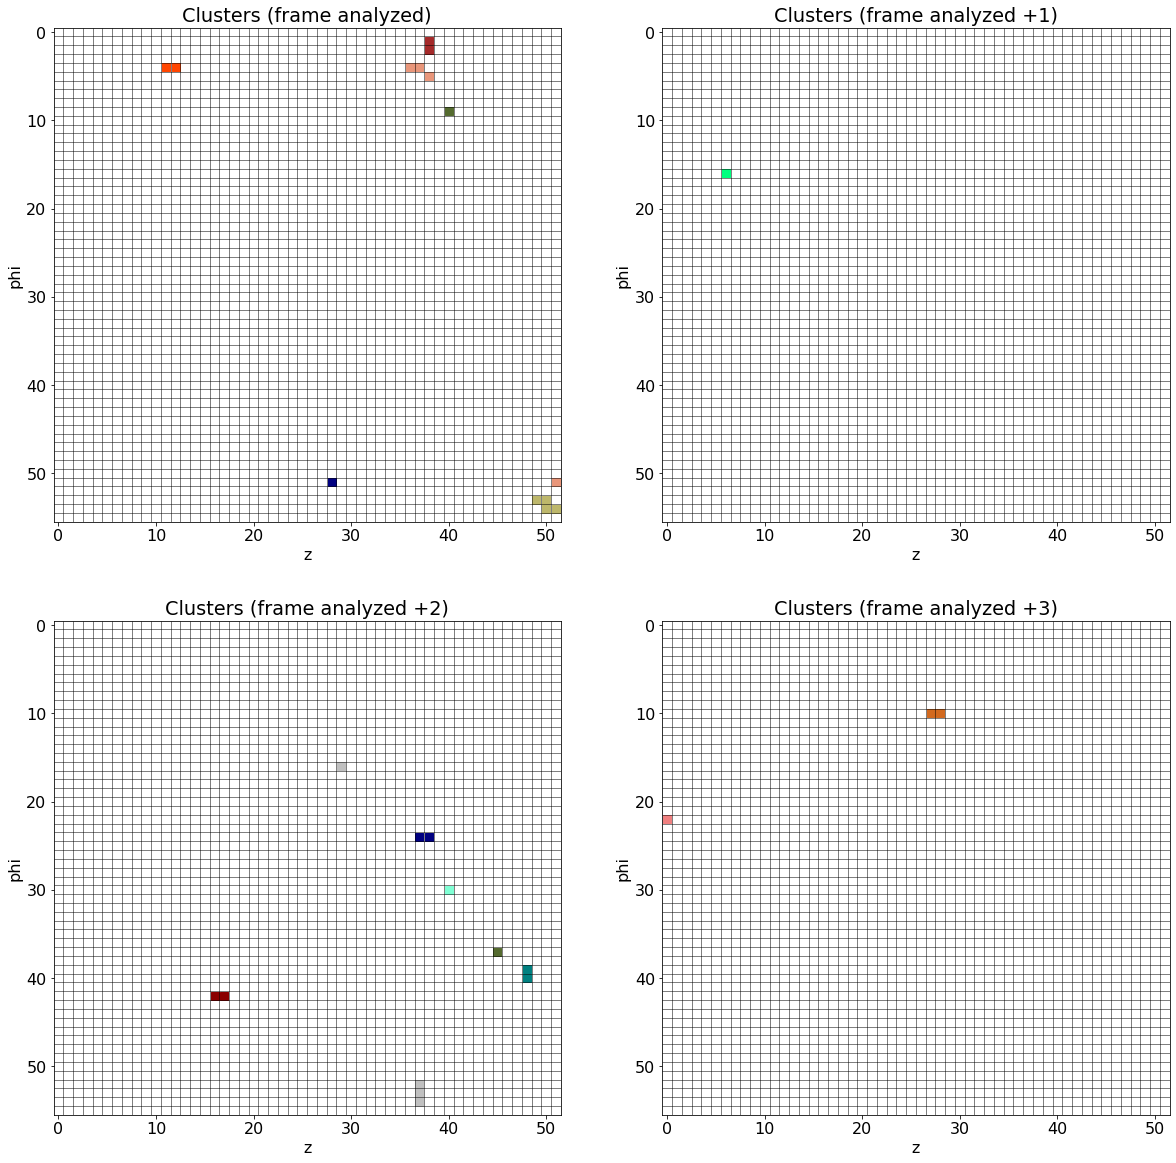

In [8]:
ttree_mu3e.GetEntry(frame_used)
ttree_mu3e_big.GetEntry(frame_used)

#plot clusters
fig, ax = plt.subplots(2,2, figsize=(20,20))

#plot clusters in frame_analyzed
clusters1 = tclump.time_clustering_frame_improv(ttree_mu3e, ttree_mu3e_mc, frame_used, time_threshold_used)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters_1 = []
whole_clusters_1 = []
for i in range(len(clusters)):
    cluster_masters_1.append(clusters1[i].master_id)
    whole_clusters_1.append(clusters1[i].get_tile_ids())
###########################    
#print(whole_clusters_1[6])

#for tile2 in whole_clusters_1[6]:
#    tile_det = mu3e_detector.TileDetector.tile[tile2] 
#    if tile2 < 300000:
#        y = tile_det.row()
#        x = tile_det.column()
#        ax[0,0].scatter(x, y, color = "b", marker = "o", s = 32)
#############################
    
for i in range(len(whole_clusters_1)):
    for j in whole_clusters_1[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[0,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("Clusters (frame analyzed)")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")
ax[0,0].set_xlim(-0.5,51.5)
ax[0,0].set_ylim(-0.5,55.5)
ax[0,0].invert_yaxis()


#plot clusters in frame_analyzed +1
ttree_mu3e.GetEntry(frame_used+1)
ttree_mu3e_big.GetEntry(frame_used+1)
clusters2 = tclump.time_clustering_frame_improv(ttree_mu3e, ttree_mu3e_mc, frame_used+1, time_threshold_used)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters2 = []
whole_clusters2 = []
for i in range(len(clusters2)):
    cluster_masters2.append(clusters2[i].master_id)
    whole_clusters2.append(clusters2[i].get_tile_ids())
    
for i in range(len(whole_clusters2)):
    for j in whole_clusters2[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[0,1].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Clusters (frame analyzed +1)")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")
ax[0,1].set_xlim(-0.5,51.5)
ax[0,1].set_ylim(-0.5,55.5)
ax[0,1].invert_yaxis()


#plot clusters in frame_analyzed +2
ttree_mu3e.GetEntry(frame_used+2)
ttree_mu3e_big.GetEntry(frame_used+2)
clusters3 = tclump.time_clustering_frame_improv(ttree_mu3e, ttree_mu3e_mc, frame_used+2, time_threshold_used)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters3 = []
whole_clusters3 = []
for i in range(len(clusters3)):
    cluster_masters3.append(clusters3[i].master_id)
    whole_clusters3.append(clusters3[i].get_tile_ids())
    
for i in range(len(whole_clusters3)):
    for j in whole_clusters3[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters (frame analyzed +2)")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
ax[1,0].set_xlim(-0.5,51.5)
ax[1,0].set_ylim(-0.5,55.5)
ax[1,0].invert_yaxis()


#plot clusters in frame_analyzed +3
ttree_mu3e.GetEntry(frame_used+3)
ttree_mu3e_big.GetEntry(frame_used+3)
clusters4 = tclump.time_clustering_frame_improv(ttree_mu3e, ttree_mu3e_mc, frame_used+3, time_threshold_used)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters4 = []
whole_clusters4 = []
for i in range(len(clusters4)):
    cluster_masters4.append(clusters4[i].master_id)
    whole_clusters4.append(clusters4[i].get_tile_ids())
    
for i in range(len(whole_clusters4)):
    for j in whole_clusters4[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,1].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[1,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,1].set_title("Clusters (frame analyzed +3)")
ax[1,1].set_xlabel("z")
ax[1,1].set_ylabel("phi")
ax[1,1].set_xlim(-0.5,51.5)
ax[1,1].set_ylim(-0.5,55.5)
ax[1,1].invert_yaxis()

ttree_mu3e.GetEntry(frame_used)
ttree_mu3e_big.GetEntry(frame_used)

In [9]:
time_clusters = tclump.time_clustering_frame_improv(ttree_mu3e, ttree_mu3e_mc, frame_used, time_threshold = 1.2)

In [10]:
cluster_len = []
masters = []
for cluster in time_clusters:
    cluster_len.append(cluster.__len__())
    masters.append(cluster.master_id)
    
index = np.where(cluster_len == np.max(cluster_len))[0][0]
print("Maximum cluster length: ", np.max(cluster_len))
print("Index of cluster with maximum length: ", index)
print("Cluster with maximum length: ", time_clusters[index])
print("Number of hits in frame: ", ttree_mu3e.Ntilehit)
print("Number of hits in clusters: " , np.sum(cluster_len))
print("Number of clusters: ", len(time_clusters))

Maximum cluster length:  4
Index of cluster with maximum length:  0
Cluster with maximum length:  Cluster(id=4, frame_id=35, master_id=202854, master_primary=48240, master_tid=48240, hits=[ClusterHit(tile_id=202854, mc_i=38240, tid=48240, frame_id=35, primary=48240, time=7304.61979027781, edep=1.949737602642886, pdg=-11, traj_PID=-100, traj_type=-100, traj_tlhid=-100, traj_ID=-100), ClusterHit(tile_id=202797, mc_i=36949, tid=48240, frame_id=35, primary=48240, time=7304.698415817301, edep=0.26538337021127817, pdg=-11, traj_PID=-100, traj_type=-100, traj_tlhid=-100, traj_ID=-100), ClusterHit(tile_id=202910, mc_i=36965, tid=48240, frame_id=35, primary=48240, time=7304.718588181294, edep=0.240648606038567, pdg=-11, traj_PID=-100, traj_type=-100, traj_tlhid=-100, traj_ID=-100), ClusterHit(tile_id=202853, mc_i=36972, tid=48240, frame_id=35, primary=48240, time=7304.744962904456, edep=0.2662771481965393, pdg=-11, traj_PID=-100, traj_type=-100, traj_tlhid=-100, traj_ID=-100)])
Number of hits i

## Efficiency Plots

In [11]:
frac_corr_frame_primary, frac_corr_clusters_frame_primary, frac_uncorr_frame_primary, tot_corr_primary = clump_plt.compare_to_primary(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, time_threshold = time_threshold_used, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "time")

Progress: 100 % of  1000  frameses
Number of analyzed frames:  1000 Number of correct counter fractions:  1000
Total #hits in frames/#hits in clusters =  1.0
Correctly associated out of all hits:  56.69296268469822 %
Correctly associated out of all hits in clusters:  56.69296268469822 %
Incorrectly associated out of all hits:  43.30703731530178 %
Incorrectly associated out of all hits in clusters:  43.30703731530178 %


In [12]:
frac_corr_frame_tid, frac_corr_clusters_frame_tid, frac_uncorr_frame_tid, tot_corr_tid, total_hits_tid, number_of_tids = clump_plt.compare_to_tid(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, time_threshold = time_threshold_used, threshold_cluster_width= 20, mask_type = "big", number_of_frames = None, rec_type = None, cluster_type = "time")

KeyboardInterrupt: 

### Hits not included in any cluster

In [ ]:
frac_not_in_cluster = clump_plt.get_hits_not_in_cluster(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, time_threshold = time_threshold_used, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "time")

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_not_in_cluster, bins = 100)
plt.title("Not associated hits / all hits in clusters (per frame)")
plt.show()

### Hits associated to wrong cluster

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_uncorr_frame_primary, bins = 100)
plt.title("Incorrectly associated hits / all hits in clusters (per frame)")
plt.show()

### Hits correctly associated

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in frame (per frame)")
plt.svaefig("correctly_associated_hits_time.png", dpi = 300)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in clusters (per frame)")
plt.show()

### Combined Histograms

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100, label = "Hits correctly associated to cluster / All hits in clusters")
plt.hist(frac_uncorr_frame_primary, bins = 100, label = "Hits incorrectly associated to cluster / All hits in clusters")
plt.title("Correctly and incorrectly associated hits / all hits in clusters (per frame)")
plt.legend()
plt.show()

### Time differences of sorted hits

In [ ]:
delta_ts_frame = clump.plots.delta_t_frame(ttree_mu3e_big, ttree_mu3e_mc_big, number_of_frames = 1000)

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(delta_ts_frame, bins = 300)
plt.yscale("log")
#plt.xlim(0,5)
plt.show()

In [ ]:
delta_ts_tot, delta_ts_same_tid, delta_ts_diff_tid = clump.plots.delta_t_frames_truth(ttree_mu3e_big, ttree_mu3e_mc_big, number_of_frames = 1000)

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(delta_ts_diff_tid, bins = 300, label = "Time difference between two hits with different TID")
plt.hist(delta_ts_same_tid, bins = 300, label = "Time difference between two hits with same TID")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(delta_ts_tot, bins = 300, label = "Time difference between two hits $\Delta$t")
plt.hist(delta_ts_same_tid, bins = 300, label = "Time difference $\Delta$t between two hits from the same truth cluster")
plt.yscale("log")
plt.xlabel(r'$\Delta$t [ns]')
plt.ylabel(r'Number of entries')
plt.title(r'Time differences $\Delta$t between hits in individual frames')
plt.legend(loc='best')
plt.xlim(-0.1)
plt.legend()
#plt.savefig("delta_t_frames.png", dpi = 300)
plt.show()

In [ ]:
import scipy.stats as ss
from scipy.optimize import curve_fit
fig = plt.figure(figsize=(12,6))

#Define fit function.
#def fit_function(x, A, beta, B, mu, sigma):
    #return (A * np.exp(-x/beta) + B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))
#def fit_function(x,A,Beta):
#    A * np.exp(-x/beta)
    

def fit_function_exp(x, a, b, c):
    tmp= a * np.exp(-b * x) + c
    return tmp

def fit_function_lin(x, a, b):
    tmp= a * x + b
    return tmp

def fit_function_exp_exp(x, a_1, b_1, c_1, a_2, b_2, c_2):
    tmp= a_1 * np.exp(-b_1 * x) + c_1 + a_2 * np.exp(-b_2 * x) + c_2
    return tmp

#Fit the function to the histogram data.
bins = np.linspace(0, 64, 300)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
data_entries_1, bins_1 = np.histogram(delta_ts_frame, bins=bins)
#popt, pcov = curve_fit(fit_function_exp, xdata=binscenters[50:150], ydata=data_entries_1[50:150], p0=[10, 1.3, 0.5])
#print(popt)

xspace = np.linspace(0,64, 10000)

# Plot the histogram and the fitted function.
plt.bar(binscenters, data_entries_1, width=bins[1] - bins[0], label=r'Histogram entries')
#plt.plot(xspace, fit_function_exp(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted exponential function')
#plt.plot(xspace, fit_function_exp_exp(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted exponential function')

#Add linear fir for peak
#popt_lin, pcov_lin = curve_fit(fit_function_exp, xdata=binscenters[0:8], ydata=data_entries_1[0:8], p0=[10, 1.3, 0.5])
#plt.plot(xspace, fit_function_exp(xspace, *popt_lin), color='red', linewidth=2.5, label=r'Fitted offset function')

#expexp
popt, pcov = curve_fit(fit_function_exp_exp, xdata=binscenters, ydata=data_entries_1, p0=[2.23596507e+04,  2.02781182e-01, -2.38379280e+00, 1.87774781e+06, 8.36130622e+00, 2.75967865e+04])
plt.plot(xspace, fit_function_exp_exp(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
print(popt)

# Make the plot nicer.
plt.xlim(0,64)
plt.xlabel(r'$\Delta$t [ns]')
plt.ylabel(r'Number of entries')
plt.title(r'Time differences between hits in individual frames including fit')
plt.legend(loc='best')
plt.yscale("log")
plt.ylim(1)
plt.xlim(0,5)
#plt.savefig("fitted_time_differences_frame.png", dpi = 300)
plt.show()
#plt.clf()

In [ ]:
delta_ts_clusters = clump.plots.delta_t_clusters(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, 
                                                 ttree_tiles_big,  mu3e_detector, time_threshold = 1.2, 
                                                 threshold_cluster_width = 30, mask_type = "big", 
                                                 number_of_frames = 1000, rec_type = None, cluster_type = "truth")

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(delta_ts_clusters, bins = 300)
plt.yscale("log")
plt.show()

In [ ]:
delta_ts_frame_to_frame = clump.plots.delta_t_between_frames(ttree_mu3e_big, ttree_mu3e_mc_big, number_of_frames = 1000)

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(delta_ts_frame_to_frame, bins = 300)
plt.yscale("log")
plt.show()

### Average number of hits per time cluster

In [ ]:
mean_cluster_hits, mean_clusters_frame, mean_hits_frame = tclump.average_number_of_cluster_hits(ttree_mu3e_big, ttree_mu3e_mc_big, number_of_frames = None, time_threshold = 1.2)

In [ ]:
print(mean_cluster_hits)
print(mean_clusters_frame)
print(mean_hits_frame)